# Install and Import Libraries


In [ ]:
!pip install torch
!pip install transformers
!pip install datasets
!pip install sentencepiece
!pip install evaluate
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
# General purpose libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evaluate import load

In [ ]:
# transformers library
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AdamW, BartTokenizer, BartForConditionalGeneration, PegasusForConditionalGeneration, PegasusTokenizer

In [ ]:
# torch library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
# Download the nltk punkt tokenizer if not already downloaded
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
MY_GPU = torch.device('cuda')
MY_GPU

1
Tesla T4


device(type='cuda')

# 1) Dataset loading and preprocessing

Dataset obtained from https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots

## Load the dataset and drop rows with missing vlaues

In [ ]:
current_dir = os.getcwd()
current_dir

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/....../wiki_movie_dataset.csv'
df = pd.read_csv(file_path, encoding='utf-8-sig')
df = df.dropna()
df

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
13,1907,Daniel Boone,American,Wallace McCutcheon and Ediwin S. Porter,"William Craven, Florence Lawrence",biographical,https://en.wikipedia.org/wiki/Daniel_Boone_(19...,Boone's daughter befriends an Indian maiden as...
14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...
15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...
16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...
...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...


## Keep only the entries in English language from the dataset

In [ ]:
df['Origin/Ethnicity'].value_counts()

American        17060
British          3636
Bollywood        2849
Tamil            2559
Telugu           1278
Malayalam        1065
Japanese          822
Canadian          658
Hong Kong         648
Australian        466
Kannada           444
Chinese           440
South_Korean      419
Bengali           298
Russian           195
Marathi           141
Filipino          128
Bangladeshi        86
Punjabi            84
Egyptian           67
Turkish            60
Malaysian          50
Assamese            9
Maldivian           2
Name: Origin/Ethnicity, dtype: int64

In [ ]:
selected_origins = ['American', 'British', 'Australian', 'Canadian']
df_en = df[df['Origin/Ethnicity'].isin(selected_origins)]
df_en

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
13,1907,Daniel Boone,American,Wallace McCutcheon and Ediwin S. Porter,"William Craven, Florence Lawrence",biographical,https://en.wikipedia.org/wiki/Daniel_Boone_(19...,Boone's daughter befriends an Indian maiden as...
14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...
15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...
16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...
...,...,...,...,...,...,...,...,...
22426,2017,The Crescent,Canadian,Seth A. Smith,"Danika Vandersteen, Woodrow Graves, Terrance M...",horror,https://en.wikipedia.org/wiki/The_Crescent_(film),"After the death of her husband, Beth with her ..."
22427,2017,Goon: Last of the Enforcers,Canadian,Jay Baruchel,"Seann William Scott, Liev Schrieber, Elisha Cu...","comedy, sports",https://en.wikipedia.org/wiki/Goon:_Last_of_th...,"During a pro hockey lockout, Doug ""The Thug"" G..."
22428,2017,"Hochelaga, Land of Souls (Hochelaga terre des ...",Canadian,François Girard,"Raoul Max Trujillo, Tanaya Beatty, David La Haye",historical drama,"https://en.wikipedia.org/wiki/Hochelaga,_Land_...","One night on the campus of McGill University, ..."
22429,2017,Indian Horse,Canadian,Stephen Campanelli,"Forrest Goodluck, Michiel Huisman, Michael Mur...",drama,https://en.wikipedia.org/wiki/Indian_Horse_(film),"The Indian Horse family, including six-year-ol..."


## Define the final dataset having the 'Title', 'Plot' and 'Genre' columns

In [ ]:
df_final = df_en[['Title', 'Plot','Genre']].reset_index(drop=True)
df_final

,Title,Plot,Genre
0,Alice in Wonderland,"Alice follows a large white rabbit down a ""Rab...",unknown
1,Daniel Boone,Boone's daughter befriends an Indian maiden as...,biographical
2,How Brown Saw the Baseball Game,Before heading out to a baseball game at a nea...,comedy
3,Laughing Gas,The plot is that of a black woman going to the...,comedy
4,The Adventures of Dollie,On a beautiful summer day a father and mother ...,drama
...,...,...,...
21815,The Crescent,"After the death of her husband, Beth with her ...",horror
21816,Goon: Last of the Enforcers,"During a pro hockey lockout, Doug ""The Thug"" G...","comedy, sports"
21817,"Hochelaga, Land of Souls (Hochelaga terre des ...","One night on the campus of McGill University, ...",historical drama
21818,Indian Horse,"The Indian Horse family, including six-year-ol...",drama


## Dataset observation

Retrieve valuable information from the dataset to assess its qualitative and quantitative characteristics.

### Plot observation

In [ ]:
# Tokenize each paragraph in the 'Plot' column and calculate the number of tokens
plot_df = pd.DataFrame()
plot_df['Plot'] = df_final['Plot']
plot_df['NumTokens'] = df_final['Plot'].apply(lambda x: len(word_tokenize(x)))

In [ ]:
# Calculate min, max, and average number of tokens
min_tokens = plot_df['NumTokens'].min()
max_tokens = plot_df['NumTokens'].max()
avg_tokens = plot_df['NumTokens'].mean()

print(f"Minimum number of tokens: {min_tokens}")
print(f"Maximum number of tokens: {max_tokens}")
print(f"Average number of tokens: {avg_tokens}")

Minimum number of tokens: 4
Maximum number of tokens: 5806
Average number of tokens: 464.22910174152156


#### Get the distribution of the length (in tokens) of plots.


Result:

The majority of plots have less than 1024 tokens

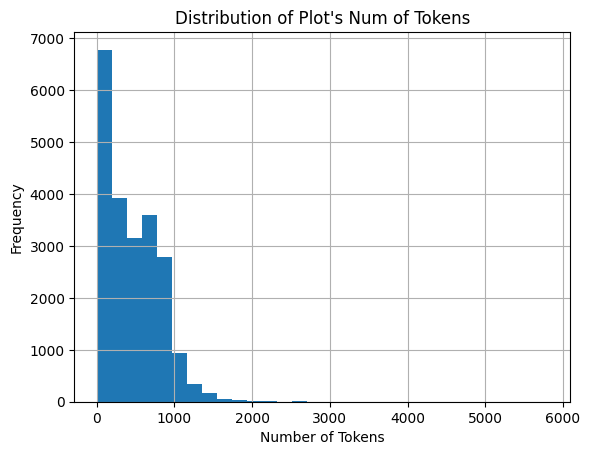

In [ ]:
plot_df['NumTokens'].hist(bins=30)
plt.title("Distribution of Plot's Num of Tokens")
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

#### Get the movies having more than 1024 tokens plot.


Result:

Totally, 1221 examples of the dataset plots are larger than 1024 tokens.

In [ ]:
big_plots = plot_df[plot_df['NumTokens'] > 1024].reset_index(drop=True)

print(big_plots)

                                                   Plot  NumTokens
0     The film follows two juxtaposed families. One ...       1094
1     Don Diego de la Vega (Zorro)'s son, Cesar (Dou...       1207
2     The film opens with the debut of the new seaso...       1652
3     The film starts out at The Merrill Department ...       1457
4     The credits (accompanied by organ music endemi...       1711
...                                                 ...        ...
1216  The film opens with scenes of plaster casts of...       1110
1217  The main objective of the film was to explain ...       3036
1218  In 1870 on the eve of the Franco-Prussian War,...       1101
1219  When eight year old Oscar Madly finds out that...       1241
1220  During a pro hockey lockout, Doug "The Thug" G...       1155

[1221 rows x 2 columns]


### Genre observation

TODO: Maybe we should consider a reduction in num of distinct genre classe. We could merge some relative classes in a single one.

In [ ]:
unique_genres = df_final['Genre'].unique()
print(f"There are {len(unique_genres)} genre classes in total.")
# for genre in unique_genres:
#   print(genre)

print(df_final['Genre'].value_counts())

There are 1082 genre classes in total.
drama                                                               4615
comedy                                                              3828
unknown                                                              996
horror                                                               977
western                                                              864
                                                                    ... 
fantasy romance, horror                                                1
adventure, disaster                                                    1
action, mystery                                                        1
drama, teen                                                            1
animated feature produced with the national film board of canada       1
Name: Genre, Length: 1082, dtype: int64


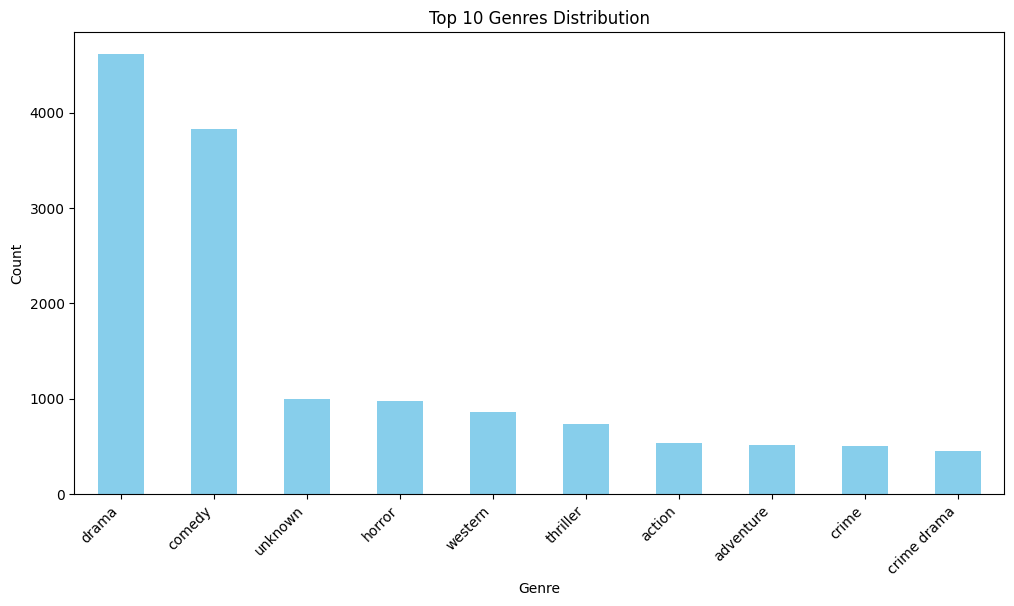

In [ ]:
df_final['Genre'].value_counts().head(10).plot(kind='bar', color='skyblue', figsize=(12, 6))
plt.title('Top 10 Genres Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

## Split the dataset into train, validation and test sets.

- Train set: 70%
- Validation set: 20%
- Test set: 10%

In [ ]:
# Initially create a Train set 70% and Test set 30%
train_df_features, temp_df_features, train_df_labels, temp_df_labels = train_test_split(df_final[['Plot', 'Genre']], df_final[['Title']], test_size=0.3, random_state=42)
# Then Split Test set to Validation (20%) and Test (10%) sets
val_df_features, test_df_features, val_df_labels, test_df_labels = train_test_split(temp_df_features, temp_df_labels,test_size=0.33, random_state=42)

# Check the sizes of the resulting sets
print(f"Train set size: {len(train_df_labels)}")
print(f"Validation set size: {len(val_df_labels)}")
print(f"Test set size: {len(test_df_labels)}")

Train set size: 15274
Validation set size: 4385
Test set size: 2161


# 2) Usage of pre-trained encoder-decoder models

TODO provide a brief description for this section

## Dataset preparation

In [ ]:
class MovieDataset(Dataset):
    def __init__(self, features, labels,tokenizer, max_length=256, max_plot_length=252, max_genre_length=4):
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.max_plot_length = max_plot_length
        self.max_genre_length = max_genre_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        summary = self.features.iloc[idx]['Plot']
        title = self.labels.iloc[idx]['Title']
        genre = self.features.iloc[idx]['Genre']

        input_plots = self.tokenizer(
            summary,
            max_length=self.max_plot_length,
            padding='max_length',
            truncation=True, # see also chunking method instead of truncation
            return_tensors='pt'
        )

        input_genres = self.tokenizer(
            genre,
            max_length=self.max_genre_length,
            padding='max_length',
            truncation=True, # see also chunking method instead of truncation
            return_tensors='pt'
        )

        labels = self.tokenizer(
            title,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_plots': input_plots['input_ids'].squeeze(),
            'input_genres': input_genres['input_ids'].squeeze(),
            'attention_mask_plot': input_plots['attention_mask'].squeeze(),
            'attention_mask_genre': input_genres['attention_mask'].squeeze(),
            'labels': labels['input_ids'].squeeze()
        }

**max_length (int, optional)**

Controls the maximum length for encoder inputs (documents to summarize or source language texts). If left unset or set to None, this will use the predefined model maximum length if a maximum length is required by one of the truncation/padding parameters. If the model has no specific maximum input length (like XLNet) truncation/padding to a maximum length will be deactivated.

See more: https://huggingface.co/transformers/v3.1.0/model_doc/bart.html#barttokenizer

**Padding**

Sentences aren’t always the same length which can be an issue because tensors, the model inputs, need to have a uniform shape. Padding is a strategy for ensuring tensors are rectangular by adding a special padding token to shorter sentences.

Set the padding parameter to True to pad the shorter sequences in the batch to match the longest sequence:

See more: https://huggingface.co/docs/transformers/pad_truncation

!!! Important for BART: It is recommended to use padding on the right side of the token sequence instead of the left

**Truncation**

On the other end of the spectrum, sometimes a sequence may be too long for a model to handle. In this case, you’ll need to truncate the sequence to a shorter length.

Set the truncation parameter to True to truncate a sequence to the maximum length accepted by the model:

**Tensors**

Finally, you want the tokenizer to return the actual tensors that get fed to the model.

Set the return_tensors parameter to either pt for PyTorch, or tf for TensorFlow.


## Tokenizer initialization


In [ ]:
def test_tokenizer(tokenizer, train_dataset, n):
    retrieved_plot = tokenizer.decode(train_dataset.__getitem__(n)['input_plots'])
    retrieved_title = tokenizer.decode(train_dataset.__getitem__(n)['labels'])
    retrieved_genre = tokenizer.decode(train_dataset.__getitem__(n)['input_genres'])
    print(retrieved_title)
    print(retrieved_plot)
    print(retrieved_genre)

    # Example usage
    sample = train_dataset[n]
    print("Input_plots:", sample['input_plots'])
    print("input_genres:", sample['input_genres'])
    print("Attention Mask Plot:", sample['attention_mask_plot'])
    print("Attention Mask Genre:", sample['attention_mask_genre'])
    print("Labels:", sample['labels'])

### Pegasus Tokenizer

- pegasus-xsum

In [ ]:
# Choose a pre-trained model
model_pegasus_name = "google/pegasus-xsum"
tokenizer_peg = PegasusTokenizer.from_pretrained(model_pegasus_name)

# Create instances of the dataset
train_dataset_peg = MovieDataset(train_df_features, train_df_labels, tokenizer_peg, max_length=128, max_plot_length=124, max_genre_length=4) # this is the encoded_input
val_dataset_peg = MovieDataset(val_df_features, val_df_labels, tokenizer_peg, max_length=128, max_plot_length=124, max_genre_length=4) # this is the encoded_input
test_dataset_peg = MovieDataset(test_df_features, test_df_labels, tokenizer_peg, max_length=128, max_plot_length=124, max_genre_length=4) # this is the encoded_input

test_tokenizer(tokenizer_peg, train_dataset_peg, 2)

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Like Minds</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Alex Forbes attends a boarding school where his father is principal. A new student, Nigel Colbie, is placed in Alex's room. Nigel has a father who is in the same secret society as Alex's father. Nigel, however, is unusual, and in Alex's words "had this morbid fascination with all things dead." Nigel keeps animals preserved in jars, and dissects them. Alex co

### Bart Tokenizer

- bart-base
- bart-base-finetuned-xsum

In [110]:
model_bart_name = "facebook/bart-base"
# model_bart_name = "Hemantjangra/bart-base-finetuned-xsum"
tokenizer_bart = BartTokenizer.from_pretrained(model_bart_name)

# Create instances of the dataset
train_dataset_bart = MovieDataset(train_df_features, train_df_labels, tokenizer_bart) # this is the encoded_input
val_dataset_bart = MovieDataset(val_df_features, val_df_labels, tokenizer_bart) # this is the encoded_input
test_dataset_bart = MovieDataset(test_df_features, test_df_labels, tokenizer_bart) # this is the encoded_input

test_tokenizer(tokenizer_bart, train_dataset_bart, 2)

<s>Like Minds</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

## Model initialization

In [ ]:
def init_peg_or_bart_model(model_name, model_type='bart'):
    # Choose a pre-trained sequence-to-sequence model
    if model_type=='pegasus':
        model = PegasusForConditionalGeneration.from_pretrained(model_name)
    else:
        model = BartForConditionalGeneration.from_pretrained(model_name)

    model.to(MY_GPU)
    optimizer = AdamW(model.parameters(), lr=5e-5)

    return model, optimizer

In [ ]:
def prepare_dataloader(train_dataset, val_dataset, test_dataset, batch_size):
    # prepare Data Loaders
    dataloader = {}
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    dataloader['train'] = train_dataloader
    dataloader['val'] = eval_dataloader
    dataloader['test'] = test_dataloader

    return dataloader

### Pegasus Model

In [ ]:
# model_peg, optimizer_peg = init_peg_or_bart_model(model_pegasus_name, model_type='pegasus')
dataloader_peg = prepare_dataloader(train_dataset_peg, val_dataset_peg, test_dataset_peg, batch_size=4)

### BART Model

In [111]:
# model_bart, optimizer_bart = init_peg_or_bart_model(model_bart_name)
dataloader_bart = prepare_dataloader(train_dataset_bart, val_dataset_bart, test_dataset_bart, batch_size=4)

## Fine-Tuning

https://huggingface.co/docs/transformers/preprocessing

### Training Loop

In [ ]:
import logging

# Configure the logging settings
logging.basicConfig(filename='/content/drive/......./BART_XSUM_wiki_movies_finetuned_3_epochs_batch4.log', encoding='utf-8', level=logging.INFO, force=True)

In [ ]:
def train_get_model(model, tokenizer, optimizer, dataloader, epoch_num):
    for epoch in range(epoch_num):
        tmp_str = '----------- EPOCH '+str(epoch+1)+'-------------'
        logging.info(tmp_str)
        train_loss = 0.0
        val_loss = 0.0
        total_bartscore = 0.0

        # Training Loop
        for batch in dataloader['train']:
            plots = batch['input_plots']
            genres = batch['input_genres']
            inputs = torch.cat([plots,genres], 1).to(MY_GPU)

            attention_mask_plot = batch['attention_mask_plot']
            attention_mask_genre = batch['attention_mask_genre']
            attention_mask = torch.cat([attention_mask_plot,attention_mask_genre], 1).to(MY_GPU)

            labels = batch['labels'].to(MY_GPU)

            optimizer.zero_grad()

            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        tmp_str = f"Epoch {epoch+1} \t\t Training Loss: {train_loss / len(dataloader['train'])}"
        logging.info(tmp_str)

        # Validation Loop
        for batch in dataloader['val']:
            plots = batch['input_plots']
            genres = batch['input_genres']
            inputs = torch.cat([plots,genres],1).to(MY_GPU)

            attention_mask_plot = batch['attention_mask_plot']
            attention_mask_genre = batch['attention_mask_genre']
            attention_mask = torch.cat([attention_mask_plot,attention_mask_genre], 1).to(MY_GPU)

            labels = batch['labels'].to(MY_GPU)

            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

        tmp_str = f"Epoch {epoch+1} \t\t Validation Loss: {val_loss / len(dataloader['val'])}"
        logging.info(tmp_str)
        tmp_str = f"Epoch {epoch+1} \t\t Validation BARTScore: {total_bartscore / len(dataloader['val'])}"
        logging.info(tmp_str)

    return model


In [ ]:
trained_bart_model = train_get_model(model_bart, tokenizer_bart, optimizer_bart, dataloader_bart, 3)
# Save the fine-tuned model
trained_bart_model.save_pretrained("/content/drive/...../BART_wiki_movies_finetuned_3_epochs")

----------- EPOCH  1 -------------


KeyboardInterrupt: 

In [ ]:
trained_peg_model = train_get_model(model_peg, tokenizer_peg, optimizer_peg, dataloader_peg, 3)
# Save the fine-tuned model
trained_peg_model.save_pretrained("/content/drive/......../PEGASUS_wiki_movies_finetuned_3_epochs")

## Results of the fine-tuned models   

### Evaluation Methods

#### BART SCORE


In [ ]:
# Create a dataset for BART SCORE training
df_new_csv = df_en[['Title', 'Plot']].reset_index(drop=True)

train_list2 = []
eval_list2 = []

a = df_new_csv.iloc[:18000,:]
for index, row in a.iterrows():
    # train_list["text"].append(row['Plot'])
    # train_list["summary"].append(row['Title'])
    train_list2.append({"text": row['Plot'], "summary": row['Title']})

b = df_new_csv.iloc[18000:,:]
for index, row in b.iterrows():
    # eval_list["text"].append(row['Plot'])
    # eval_list["summary"].append(row['Title'])
    eval_list2.append({"text": row['Plot'], "summary": row['Title']})

import json

with open("train_data2.json", 'w') as json_file:
    json.dump(train_list2, json_file)

with open("eval_data2.json", 'w') as json_file:
    json.dump(eval_list2, json_file)

In [ ]:
!git clone https://github.com/neulab/BARTScore.git
!cd '/content/BARTScore'
import sys
sys.path.insert(0,'/content/BARTScore')

Cloning into 'BARTScore'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 220 (delta 18), reused 14 (delta 14), pack-reused 194
Receiving objects: 100% (220/220), 101.98 MiB | 10.48 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Updating files: 100% (192/192), done.


Train the BARTScorer to evaluate our data with the BartScore metric

In [ ]:
!pip install accelerate
!python /content/BARTScore/train/bart.py --train_file '/content/train_data2.json' --validation_file '/content/eval_data2.json' --max_source_length 256  --output_dir /content/drive/......./BartScore_TITLES

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.0 MB/s eta 0:00:00


In [ ]:
from bart_score import BARTScorer
bart_scorer = BARTScorer(device=MY_GPU, checkpoint='/content/drive/....../BartScore_TITLES')

OSError: Can't load tokenizer for '/content/drive/MyDrive/BartScore_TITLES'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/content/drive/MyDrive/BartScore_TITLES' is the correct path to a directory containing all relevant files for a BartTokenizer tokenizer.

In [ ]:
bart_scorer.score(['This is interesting.'], ['This is interesting.'], batch_size=2)

[-0.5936542749404907]

#### BERT SCORE

In [ ]:
# Default test example
bertscore = load("bertscore")
predictions = ["hello world"]
references = ["goodnight moon"]
results = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")
print(results)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

{'precision': [0.7899678349494934], 'recall': [0.7899678349494934], 'f1': [0.7899678349494934], 'hashcode': 'distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.35.2)'}


In [130]:
def test_fine_tuned_model(model, tokenizer, dataloader, total=1):
    # print('----------------------------------------')
    total_results = {'precision': 0, 'recall': 0, 'f1': 0}
    for batch in dataloader['test']:
        total -= 1
        input_plot = batch['input_plots']
        input_genre = batch['input_genres']

        inputs = torch.cat([input_plot, input_genre], 1).to(MY_GPU)
        labels = batch['labels'].to(MY_GPU)

        output = model.generate(inputs)

        # Decode the generated title
        print('----------------------------------------')
        original_title = tokenizer.decode(labels[0], skip_special_tokens=True)
        print("Original Title:", original_title)
        generated_title = tokenizer.decode(output[0], skip_special_tokens=True)
        print("Generated Title:", generated_title)
        plot = tokenizer.decode(input_plot[0], skip_special_tokens=True)
        print("Plot:", plot)
        genre = tokenizer.decode(input_genre[0], skip_special_tokens=True)
        print('----------------------------------------')
        print('----------------------------------------')

        # print("Genre:", genre)
        # print('----------------------------------------')
        # results = bertscore.compute(predictions=[generated_title], references=[original_title], model_type="distilbert-base-uncased")
        # total_results['precision'] += results['precision'][0]
        # total_results['recall'] += results['recall'][0]
        # total_results['f1'] += results['f1'][0]
        # print("Bertscore:")
        # print("       Precision: ", results['precision'])
        # print("       Recall   : ", results['recall'])
        # print("       F1 Score : ", results['f1'])
        # print('========================================')
        if total == 0:
          break

    # total_results['precision'] = total_results['precision'] / len(dataloader['test'])
    # total_results['recall'] = total_results['recall'] / len(dataloader['test'])
    # total_results['f1'] = total_results['f1'] / len(dataloader['test'])

    return total_results



### BART fine-tuned model

In [112]:
# Load the fine-tuned model
bart_fine_tuned_model = BartForConditionalGeneration.from_pretrained("/content/drive/......../trained_models/BART_base_wiki_movies_finetuned_3_epochs_batch4")
bart_fine_tuned_model.to(MY_GPU)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

In [148]:
test_fine_tuned_model(bart_fine_tuned_model, tokenizer_bart, dataloader_bart, total=10)

----------------------------------------
Original Title: Grosse Pointe Blank
Generated Title: Grosse Pointe
Plot: Professional assassin Martin Blank finds himself depressed and disillusioned with his work. Grocer, his chief rival, is attempting to incorporate the hitman business, but Martin refuses to join, putting the two at odds. Following a botched contract, Martin accepts an invitation to his 10-year high school reunion in his hometown of Grosse Pointe, Michigan. He is persuaded into going by both his reluctant therapist, Dr. Oatman, and his secretary Marcella, who books him a contract in Michigan that coincides with the reunion, ostensibly to make amends with the client whose contract was botched.
Upon arriving in Grosse Pointe, Martin reconnects with his childhood friend Paul and his high school sweetheart Debi Newberry, now a radio disc jockey, whom Martin had abandoned on prom night to enlist in the army. He also visits his mentally ill mother in a retirement home, and his fath

{'precision': 0, 'recall': 0, 'f1': 0}

### PEGASUS fine-tuned model

In [ ]:
# Load the fine-tuned model
path = "/content/drive/........./trained_models/PEGASUS_XSUM_wiki_movies_finetuned_3epochs_batch4_128input_final"

peg_fine_tuned_model = PegasusForConditionalGeneration.from_pretrained(path, local_files_only=True)
peg_fine_tuned_model.to(MY_GPU)

PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(512, 1024)
      (layers): ModuleList(
        (0-15): 16 x PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_nor

In [69]:
test_fine_tuned_model(peg_fine_tuned_model, tokenizer_peg, dataloader_peg)

{'precision': 0.7081029155722154,
 'recall': 0.7104247750396366,
 'f1': 0.7084749557805359}

In [68]:
test_fine_tuned_model(loaded_model, tokenizer_bart, custom_dataloader)

AttributeError: 'Transformer' object has no attribute 'generate'

### Test example

In [77]:
def test_diff_genres(dataloader, tokenizer, fine_tuned_model):
    total = 1
    print('----------------------------------------')
    for batch in dataloader['test']:
      total -= 1
      plots = batch['input_plots']
      genre1 = 'comedy'
      genre2 = 'drama'
      genre3 = 'horror'
      genre_1 = tokenizer(
          genre1,
          max_length=4,
          padding='max_length',
          truncation=True, # see also chunking method instead of truncation
          return_tensors='pt'
      )['input_ids']
      genre_2 = tokenizer(
          genre2,
          max_length=4,
          padding='max_length',
          truncation=True, # see also chunking method instead of truncation
          return_tensors='pt'
      )['input_ids']
      genre_3 = tokenizer(
          genre3,
          max_length=4,
          padding='max_length',
          truncation=True, # see also chunking method instead of truncation
          return_tensors='pt'
      )['input_ids']

      inputs_1 = torch.cat([plots,genre_1],1).to(MY_GPU)
      inputs_2 = torch.cat([plots,genre_2],1).to(MY_GPU)
      inputs_3 = torch.cat([plots,genre_3],1).to(MY_GPU)

      labels = batch['labels'].to(MY_GPU)

      # input_ids = tokenizer(inputs, return_tensors='pt')['input_ids']
      # output = model.generate(inputs)
      output1 = fine_tuned_model.generate(inputs_1)
      output2 = fine_tuned_model.generate(inputs_2)
      output3 = fine_tuned_model.generate(inputs_3)

      # Decode the generated title
      original_title = tokenizer.decode(labels[0], skip_special_tokens=True)
      print("Original Title:", original_title)
      generated_title = tokenizer.decode(output1[0], skip_special_tokens=True)
      print("Generated Title:", generated_title)
      plot = tokenizer.decode(inputs_1[0][:-4], skip_special_tokens=True)
      print("Plot:", plot)
      genre = tokenizer.decode(inputs_1[0][-4:], skip_special_tokens=True)
      print("Genre:", genre)
      print('----------------------------------------')
      original_title = tokenizer.decode(labels[0], skip_special_tokens=True)
      print("Original Title:", original_title)
      generated_title = tokenizer.decode(output2[0], skip_special_tokens=True)
      print("Generated Title:", generated_title)
      plot = tokenizer.decode(inputs_2[0][:-4], skip_special_tokens=True)
      print("Plot:", plot)
      genre = tokenizer.decode(inputs_2[0][-4:], skip_special_tokens=True)
      print("Genre:", genre)
      print('----------------------------------------')
      original_title = tokenizer.decode(labels[0], skip_special_tokens=True)
      print("Original Title:", original_title)
      generated_title = tokenizer.decode(output3[0], skip_special_tokens=True)
      print("Generated Title:", generated_title)
      plot = tokenizer.decode(inputs_3[0][:-4], skip_special_tokens=True)
      print("Plot:", plot)
      genre = tokenizer.decode(inputs_3[0][-4:], skip_special_tokens=True)
      print("Genre:", genre)
      print('----------------------------------------')
      if total == 0:
        break

In [125]:
def test_single_example_diff_genres(dataloader, tokenizer, fine_tuned_model):
    plots = "A dramatization of the life story of J. Robert Oppenheimer, the physicist who had a large hand in the development of the atomic bomb, thus helping end World War 2. We see his life from university days all the way to post-WW2, where his fame saw him embroiled in political machinations."
    genre1 = 'comedy'
    genre2 = 'drama'
    genre3 = 'western'
    plots = tokenizer(plots, max_length=124, padding='max_length', truncation=True, return_tensors='pt')['input_ids']
    genre_1 = tokenizer(
        genre1,
        max_length=4,
        padding='max_length',
        truncation=True, # see also chunking method instead of truncation
        return_tensors='pt'
    )['input_ids']
    genre_2 = tokenizer(
        genre2,
        max_length=4,
        padding='max_length',
        truncation=True, # see also chunking method instead of truncation
        return_tensors='pt'
    )['input_ids']
    genre_3 = tokenizer(
        genre3,
        max_length=4,
        padding='max_length',
        truncation=True, # see also chunking method instead of truncation
        return_tensors='pt'
    )['input_ids']

    inputs_1 = torch.cat([plots,genre_1],1).to(MY_GPU)
    inputs_2 = torch.cat([plots,genre_2],1).to(MY_GPU)
    inputs_3 = torch.cat([plots,genre_3],1).to(MY_GPU)

    # labels = batch['labels'].to(MY_GPU)

    # input_ids = tokenizer(inputs, return_tensors='pt')['input_ids']
    # output = model.generate(inputs)
    output1 = fine_tuned_model.generate(inputs_1)
    output2 = fine_tuned_model.generate(inputs_2)
    output3 = fine_tuned_model.generate(inputs_3)

    # Decode the generated title
    generated_title = tokenizer.decode(output1[0], skip_special_tokens=True)
    print("Generated Title:", generated_title)
    plot = tokenizer.decode(inputs_1[0][:-4], skip_special_tokens=True)
    print("Plot:", plot)
    genre = tokenizer.decode(inputs_1[0][-4:], skip_special_tokens=True)
    print("Genre:", genre)
    print('----------------------------------------')
    generated_title = tokenizer.decode(output2[0], skip_special_tokens=True)
    print("Generated Title:", generated_title)
    plot = tokenizer.decode(inputs_2[0][:-4], skip_special_tokens=True)
    print("Plot:", plot)
    genre = tokenizer.decode(inputs_2[0][-4:], skip_special_tokens=True)
    print("Genre:", genre)
    print('----------------------------------------')
    generated_title = tokenizer.decode(output3[0], skip_special_tokens=True)
    print("Generated Title:", generated_title)
    plot = tokenizer.decode(inputs_3[0][:-4], skip_special_tokens=True)
    print("Plot:", plot)
    genre = tokenizer.decode(inputs_3[0][-4:], skip_special_tokens=True)
    print("Genre:", genre)
    print('----------------------------------------')


In [126]:
test_single_example_diff_genres(dataloader_peg, tokenizer_peg, peg_fine_tuned_model)

Generated Title: Oppenheimer
Plot: A dramatization of the life story of J. Robert Oppenheimer, the physicist who had a large hand in the development of the atomic bomb, thus helping end World War 2. We see his life from university days all the way to post-WW2, where his fame saw him embroiled in political machinations.
Genre: comedy
----------------------------------------
Generated Title: Oppenheimer
Plot: A dramatization of the life story of J. Robert Oppenheimer, the physicist who had a large hand in the development of the atomic bomb, thus helping end World War 2. We see his life from university days all the way to post-WW2, where his fame saw him embroiled in political machinations.
Genre: drama
----------------------------------------
Generated Title: Oppenheimer
Plot: A dramatization of the life story of J. Robert Oppenheimer, the physicist who had a large hand in the development of the atomic bomb, thus helping end World War 2. We see his life from university days all the way t

In [ ]:
test_diff_genres(dataloader_peg, tokenizer_peg, peg_fine_tuned_model)

----------------------------------------
Original Title: All My Sons
Generated Title: The Kellers of Chicago
Plot: Joe Keller is sorry to hear son Chris plans to wed Ann Deever and move to Chicago, for he hoped Chris would someday take over the manufacturing business Joe built from the ground up. Joe's business partner used to be Ann's father Herb, but when both men were charged with shipping defective airplane parts that resulted in wartime crashes and deaths, only Herb was convicted and sent to prison. Another son of the Kellers is in the Army air corps, missing in action and presumed dead. Ann used to be engaged to him and her engagement to his brother upsets Kate Keller, who hasn't yet comedy
----------------------------------------
Original Title: All My Sons
Generated Title: The Kellers of Chicago
Plot: Joe Keller is sorry to hear son Chris plans to wed Ann Deever and move to Chicago, for he hoped Chris would someday take over the manufacturing business Joe built from the ground 

In [ ]:
test_diff_genres(dataloader_bart, tokenizer_bart, bart_fine_tuned_model)

----------------------------------------
Original Title: Green Grow the Rushes
Generated Title: The Long Gray Line
Plot: Three British government bureaucrats arrive in Kent to inquire as to why the coastal Anderida marsh is not being cultivated. The reason is that most of the local people know about or are involved in the liquor smuggling scheme operated by Captain Biddle and his accomplice Robert (Richard Burton), who is posing as a fisherman when he is seen by the newspaper editor and his journalist daughter Meg.
Robert persuades them not to report it in the newspaper, and tells Biddle about his encounter with them. Biddle does not like the idea of any local "Lily White" (woman) knowing about their illegal activity; he was once married to a Lily White. The smugglers’ next cargo gets caught in a violent storm, and their boat washes inland, settling in the meadow of a farmer whose wife Polly happens to be Biddle’s ex-wife.
Genre: comedy
----------------------------------------
Original

# 3) Non-pretrained Encoder-Decoder models with transformers.

In this section we experiment with various transformers architectures and try to implement an encoder-decoder model from scratch. Then, the implemented models are trained only in our datasetes. The aim is to evaluate the performance of a non-pretrained model compared to the pre-trained and fine-tuned models from the previous section.  

## The model

### Model 1

In [ ]:
import math
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Transformer):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__(d_model=ninp, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers)
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        self.input_emb = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        return torch.log(torch.tril(torch.ones(sz,sz)))

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, input_plots, input_genres, has_mask=True):
        if has_mask:
            device = input_plots.device
            if self.src_mask is None or self.src_mask.size(0) != len(input_plots):
                mask = self._generate_square_subsequent_mask(len(input_plots)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None

        src = self.input_emb(input_plots) * math.sqrt(self.ninp)
        src_genre = self.input_emb(input_genres) * math.sqrt(self.ninp)  # Assuming input embedding is shared
        src = src + self.pos_encoder(src)
        src_genre = src_genre + self.pos_encoder(src_genre)

        # Concatenate input_plots and input_genres along the sequence dimension
        src = torch.cat((src, src_genre), dim=1)

        output = self.encoder(src, mask=self.src_mask)
        output = self.decoder(output)

        return F.log_softmax(output, dim=-1)


### Model 2

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, inputs):
        attn_output, _ = self.attention(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.att1 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate)
        self.att2 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm3 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, inputs, enc_output):
        attn_output1, _ = self.att1(inputs, inputs, inputs)
        attn_output1 = self.dropout1(attn_output1)
        out1 = self.layernorm1(inputs + attn_output1)

        attn_output2, _ = self.att2(out1, enc_output, enc_output)
        attn_output2 = self.dropout2(attn_output2)
        out2 = self.layernorm2(out1 + attn_output2)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        return self.layernorm3(out2 + ffn_output)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, vocab_size, dropout_rate=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(vocab_size, embed_dim)
        self.embedding_label = nn.Embedding(vocab_size, embed_dim)
        self.encoder = nn.ModuleList([TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout_rate) for _ in range(num_layers)])
        self.decoder = nn.ModuleList([TransformerDecoderLayer(embed_dim, num_heads, ff_dim, dropout_rate) for _ in range(num_layers)])
        self.final_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, inputs, labels):
        enc_output = self.embedding_input(inputs)
        for encoder in self.encoder:
            enc_output = encoder(enc_output)

        dec_output = self.embedding_label(labels)
        for decoder in self.decoder:
            dec_output = decoder(dec_output, enc_output)

        final_output = self.final_layer(dec_output)
        return final_output


    # def generate(self, tokenizer, input_plot, input_genre, max_length=20, temperature=1.0):
    #     self.eval()
    #     with torch.no_grad():
    #         input_plot_tokens = tokenizer.tokenize(input_plot, max_length)
    #         input_genre_tokens = tokenizer.tokenize(input_genre, max_length)
    #         input_tokens = input_plot_tokens + input_genre_tokens
    #         input_tokens = input_tokens[:max_length]

    #         inputs = torch.tensor(input_tokens).unsqueeze(0).to(MY_GPU)
    #         generated_sequence = inputs.clone()

    #         for _ in range(max_length):
    #             outputs = self(generated_sequence)

    #             if outputs is None:
    #                 break

    #             logits = outputs[:, -1, :] / temperature
    #             probabilities = F.softmax(logits, dim=-1)
    #             next_token = torch.multinomial(probabilities, 1)

    #             # Append the next token to the sequence
    #             generated_sequence = torch.cat([generated_sequence, next_token.unsqueeze(1)], dim=-1)

    #         # Decode the generated sequence
    #         generated_title = tokenizer.decode(generated_sequence[0], skip_special_tokens=True)

    #     return generated_title

    # def generate(self, input_sequence, max_length, temperature=1.0):
    #     """
    #     Generate a sequence given an input sequence.

    #     Parameters:
    #     - input_sequence (torch.Tensor): Input sequence tensor.
    #     - max_length (int): Maximum length of the generated sequence.
    #     - temperature (float): Temperature parameter for sampling. Higher values increase randomness.

    #     Returns:
    #     - generated_sequence (torch.Tensor): Generated sequence tensor.
    #     """
    #     with torch.no_grad():
    #         # Initialize generated sequence with the provided input
    #         generated_sequence = input_sequence.clone()

    #         for _ in range(max_length):
    #             # Get the model's output for the current generated sequence
    #             outputs = self(generated_sequence, labels=None)

    #             # Apply softmax and sample from the distribution using temperature
    #             probs = F.softmax(outputs[0] / temperature, dim=-1)
    #             sampled_token_index = torch.multinomial(probs, 1).squeeze()

    #             # Append the sampled token to the generated sequence
    #             generated_sequence = torch.cat([generated_sequence, sampled_token_index.unsqueeze(0)])

    #             # If the generated sequence reaches the maximum length or produces an end token, stop
    #             if len(generated_sequence) >= max_length:
    #                 break

    #     return generated_sequence

### Model 3

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=256):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()

class CustomTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=8, num_encoder_layers=6, num_decoder_layers=6):
        super(CustomTransformerModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer layers
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead),
            num_layers=num_encoder_layers
        )
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead),
            num_layers=num_decoder_layers
        )

        # Final linear layer for prediction
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.embedding(tgt)

        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)

        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(tgt, memory)

        output = self.fc(output)
        # output = self.fc(output.squeeze(0))

        return output


    def generate(self, src, max_length):
        self.eval()

        src = self.embedding(src)
        src = self.positional_encoding(src)
        memory = self.transformer_encoder(src)

        output = torch.tensor([[self.fc.out_features - 1]]).to(src.device)  # Start with the end token

        for _ in range(max_length):
            tgt = self.embedding(output)
            tgt = self.positional_encoding(tgt)

            step_output = self.transformer_decoder(tgt, memory)
            step_output = self.fc(step_output)

            next_token = torch.argmax(step_output[:, -1, :], dim=-1).unsqueeze(1)
            output = torch.cat([output, next_token], dim=1)

            if next_token.item() == self.fc.out_features - 1:  # Stop if the end token is predicted
                break

        return output[:, 1:]

### Model 4
https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb

In [58]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [59]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [60]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [61]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [62]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [63]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask.to(MY_GPU)

        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

## Tokenizer

In [ ]:
from collections import Counter
class SimpleTokenizer:
    def __init__(self, vocab_size=1000):
        self.word_to_index = {}
        self.index_to_word = {}
        self.vocab_size = vocab_size

    def fit_on_texts(self, texts):
        # Count word frequencies in the training set
        word_counter = Counter(word.lower() for text in texts for word in text.split())

        # Select the top vocab_size words
        most_common_words = word_counter.most_common(self.vocab_size-1)

        # Build vocabulary based on the most common words
        self.word_to_index = {word: idx + 1 for idx, (word, _) in enumerate(most_common_words)}  # Reserve 0 for out-of-vocabulary
        self.index_to_word = {idx + 1: word for idx, (word, _) in enumerate(most_common_words)}

    def tokenize(self, text, max_length):
        tokens = text.lower().split()
        tokens = tokens[:max_length]
        token_ids = [self.word_to_index.get(token, 0) for token in tokens]  # Use 0 for out-of-vocabulary tokens
        return token_ids

    def decode(self, token_ids, skip_special_tokens=True):
        if isinstance(token_ids, torch.Tensor):
            token_ids = token_ids.tolist()

        words = [self.index_to_word.get(idx, '') for idx in token_ids]

        if skip_special_tokens:
            # Filter out special tokens (assuming special tokens have specific IDs, e.g., 0)
            words = [word for word in words if word and self.word_to_index.get(word, -1) != 0]

        text = ' '.join(words)
        return text

## Dataset preparation

In [ ]:
# Define a custom dataset class
class MovieDatasetCustom(Dataset):
    def __init__(self, features, labels, tokenizer, max_length=256, max_length_plot=224, max_length_genre=32):
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.max_length_plot = max_length_plot
        self.max_length_genre = max_length_genre

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        summary = self.features.iloc[idx]['Plot']
        genre = self.features.iloc[idx]['Genre']
        title = self.labels.iloc[idx]['Title']

        # tokenization
        input_plots = self.tokenizer.tokenize(summary, max_length=self.max_length_plot)
        input_genres = self.tokenizer.tokenize(genre, max_length=self.max_length_genre)
        labels = self.tokenizer.tokenize(title, max_length=self.max_length)

        # padding and conversion to tensors
        input_plots = F.pad(torch.tensor(input_plots, dtype=torch.int64), (0, self.max_length_plot - len(input_plots)))
        input_genres = F.pad(torch.tensor(input_genres, dtype=torch.int64), (0, self.max_length_genre - len(input_genres)))
        labels = F.pad(torch.tensor(labels, dtype=torch.int64), (0, self.max_length - len(labels)))

        return {
            'input_plots': input_plots,
            'input_genres': input_genres,
            'labels': labels
        }

## Tokenizer initialization

In [ ]:
# Example usage with custom tokenizer
vocab_size = 5000  # Adjust based on your dataset
custom_tokenizer = SimpleTokenizer(vocab_size=vocab_size)
custom_tokenizer.fit_on_texts(train_df_features['Plot'].tolist() + train_df_features['Genre'].tolist() + train_df_labels['Title'].tolist())


In [ ]:
# Access the vocabulary from the SimpleTokenizer instance
vocabulary_word_to_index = custom_tokenizer.word_to_index
vocabulary_index_to_word = custom_tokenizer.index_to_word

# Print or use the vocabulary
print("Word to Index:")
print(vocabulary_word_to_index)

print("\nIndex to Word:")
print(vocabulary_index_to_word)

Word to Index:
{'the': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'is': 6, 'in': 7, 'his': 8, 'he': 9, 'that': 10, 'with': 11, 'her': 12, 'for': 13, 'she': 14, 'by': 15, 'as': 16, 'on': 17, 'him': 18, 'but': 19, 'they': 20, 'at': 21, 'who': 22, 'from': 23, 'has': 24, 'an': 25, 'when': 26, 'their': 27, 'are': 28, 'after': 29, 'into': 30, 'it': 31, 'out': 32, 'be': 33, 'up': 34, 'not': 35, 'was': 36, 'while': 37, 'then': 38, 'one': 39, 'which': 40, 'them': 41, 'about': 42, 'have': 43, 'where': 44, 'will': 45, 'tells': 46, 'back': 47, 'two': 48, 'new': 49, 'been': 50, 'had': 51, 'before': 52, 'him.': 53, 'all': 54, 'finds': 55, 'only': 56, 'being': 57, 'get': 58, 'off': 59, 'find': 60, 'this': 61, 'also': 62, 'goes': 63, 'can': 64, 'takes': 65, 'during': 66, 'over': 67, 'however,': 68, 'man': 69, 'other': 70, 'so': 71, 'go': 72, 'take': 73, 'her.': 74, 'through': 75, 'police': 76, 'tries': 77, 'next': 78, 'him,': 79, 'father': 80, 'home': 81, 'time': 82, 'down': 83, 'love': 84, 'now': 85, 'be

In [ ]:
train_dataset_custom = MovieDatasetCustom(train_df_features, train_df_labels, custom_tokenizer)
val_dataset_custom = MovieDatasetCustom(val_df_features, val_df_labels, custom_tokenizer)
test_dataset_custom = MovieDatasetCustom(test_df_features, test_df_labels, custom_tokenizer)

In [ ]:
# Example usage
sample = train_dataset_custom[1]
print("Input_plots:", sample['input_plots'])
print("input_genres:", sample['input_genres'])
print("Labels:", sample['labels'])
# custom_tokenizer.decode(sample['input_plots'])

Input_plots: tensor([  29, 1862,    6,  960,   23,    4, 1358,  840,   44,    8, 2009,   28,
           0,   16,    0,    9,   63,   47,    2,  607, 1199,    7,  478,    5,
           4,  160,  119,    0,   26,    9,  144,   21,    1,  859,   10, 3183,
          12, 2669,    9,    6,  481,  975,    2,    1,   49, 1993,    4,  196,
         305,  232,   62,  119,    0,   14,   46, 1862,   14, 2394,    1,  859,
          29,    1,  139,  542,  117, 2328,    0,  112,    0,    1,  859,    6,
           4, 1532, 1726,   13,    0,  421,   13,   39,  158, 1703,   16,  321,
          16,    0,  421,   13, 2108,    0,  278, 1201,    6,   62,  975,    2,
           0,   14,  218,    2, 1737,    2,  270,   39,  632, 4864,    2,  706,
         609,  568,  250, 3314,  142, 1282,   84,   10,   14, 3533,  257,  322,
           0,    2,   43,   39,    5,   12, 1565,   10])
input_genres: tensor([107,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 

## Model initialization

In [64]:
train_dataset_custom = MovieDataset(train_df_features, train_df_labels, tokenizer_bart)
val_dataset_custom = MovieDataset(val_df_features, val_df_labels, tokenizer_bart)
test_dataset_custom = MovieDataset(test_df_features, test_df_labels, tokenizer_bart)

### Model 2

In [ ]:
# Instantiate your Transformer model
num_layers = 6
embed_dim = 256
num_heads = 8
ff_dim = 128
vocab_size = tokenizer_bart.vocab_size

custom_model = Transformer(num_layers, embed_dim, num_heads, ff_dim, vocab_size)
custom_model.to(MY_GPU)
custom_dataloader = prepare_dataloader(train_dataset_custom, val_dataset_custom, test_dataset_custom, batch_size=4)

### Model 3

In [ ]:
vocab_size = tokenizer_bart.vocab_size  # Set your vocabulary size
custom_model = CustomTransformerModel(vocab_size=vocab_size)
custom_model.to(MY_GPU)
custom_dataloader = prepare_dataloader(train_dataset_custom, val_dataset_custom, test_dataset_custom, batch_size=4)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Model 4

In [65]:
src_vocab_size = tokenizer_bart.vocab_size
tgt_vocab_size = tokenizer_bart.vocab_size
d_model = 256
num_heads = 8
num_layers = 6
d_ff = 128
max_seq_length = 256
dropout = 0.1
import math

In [66]:
# custom_model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
# custom_model.to(MY_GPU)
custom_dataloader = prepare_dataloader(train_dataset_custom, val_dataset_custom, test_dataset_custom, batch_size=4)

## Training process

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_bart.pad_token_id)  # Ignore padding tokens during loss calculation
custom_optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.0001)

In [ ]:
# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    print(f"----------- EPOCH {epoch+1}-------------")
    custom_model.train()
    train_loss = 0.0
    val_loss = 0.0
    total_bartscore = 0.0

    for idx, batch in enumerate(custom_dataloader['train']):
        plots = batch['input_plots']
        genres = batch['input_genres']
        inputs = torch.cat([plots,genres], 1).to(MY_GPU)

        attention_mask_plot = batch['attention_mask_plot']
        attention_mask_genre = batch['attention_mask_genre']
        attention_mask = torch.cat([attention_mask_plot,attention_mask_genre], 1).to(MY_GPU)

        labels = batch['labels'].to(MY_GPU)

        custom_optimizer.zero_grad()

        outputs = custom_model(inputs, labels)

        # Flatten the outputs and targets to compute the CrossEntropyLoss
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        # loss = criterion(outputs.view(-1, outputs.size(-1)), labels[:, 1:].contiguous().view(-1))
        loss.backward()
        custom_optimizer.step()

        train_loss += loss.item()
    print(f"Epoch {epoch+1} \t\t Training Loss: {train_loss / len(custom_dataloader['train'])}")

    custom_model.eval()
    # Validation Loop
    for batch in custom_dataloader['val']:
        plots = batch['input_plots']
        genres = batch['input_genres']
        inputs = torch.cat([plots,genres],1).to(MY_GPU)

        attention_mask_plot = batch['attention_mask_plot']
        attention_mask_genre = batch['attention_mask_genre']
        attention_mask = torch.cat([attention_mask_plot,attention_mask_genre], 1).to(MY_GPU)

        labels = batch['labels'].to(MY_GPU)

        outputs = custom_model(inputs, labels)

        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        # loss = criterion(outputs.view(-1, outputs.size(-1)), labels[:, 1:].contiguous().view(-1))
        val_loss += loss.item()

    print(f"Epoch {epoch+1} \t\t Validation Loss: {val_loss / len(custom_dataloader['val'])}")
    # print(f"Epoch {epoch+1} \t\t Validation BARTScore: {total_bartscore / len(custom_dataloader['val'])}")


----------- EPOCH 1-------------
Epoch 1 		 Training Loss: 1.88711776249218
Epoch 1 		 Validation Loss: 1.5096262157398022
----------- EPOCH 2-------------


In [ ]:
torch.save(custom_model.state_dict(),"/content/drive/MyDrive/CustomModel2_with_bartTokenizer_1epoch_256maxLength_4batch.pth")

## Usage example

### Load the trained model

In [67]:
loaded_model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/ΠΛΗΡΟΦΟΡΙΚΗ ΑΠΘ/DWS/1st_Semester/DWS104_NLP/[DWS104]NLP_Project/trained_models/CustomModel2_with_bartTokenizer_13epochs_256maxLength_4batch.pth'))
loaded_model.to(MY_GPU)

Transformer(
  (encoder_embedding): Embedding(50265, 256)
  (decoder_embedding): Embedding(50265, 256)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=256, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=256, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
 

### Prepare input tokens

In [74]:
# Example usage with the trained model
example_plot = "Adam, a young child, played outside in the park when suddenly aliens came from the sky and abducted him. Will he be able to escape?"
example_genre = "fantasy"

In [ ]:
inputs = tokenizer_bart(example_plot, max_length=252,
            padding='max_length', return_tensors='pt')
inputs['input_ids']

tensor([[    0, 24671,     6,    10,   664,   920,     6,   702,   751,    11,
             5,  2221,    77,  6017, 20739,   376,    31,     5,  6360,     8,
         18782,   123,     4,  2290,    37,    28,   441,     7,  5111,   116,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [ ]:
genre_inputs = tokenizer_bart(example_genre, max_length=4,
            padding='max_length', return_tensors='pt')
genre_inputs['input_ids']

tensor([[    0,   506, 40650,     2]])

In [ ]:
inputs = torch.cat([inputs['input_ids'], genre_inputs['input_ids']], 1).to(MY_GPU)

In [ ]:
inputs

tensor([[    0, 24671,     6,    10,   664,   920,     6,   702,   751,    11,
             5,  2221,    77,  6017, 20739,   376,    31,     5,  6360,     8,
         18782,   123,     4,  2290,    37,    28,   441,     7,  5111,   116,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [ ]:
print(inputs.shape)

torch.Size([1, 256])


### Inference

In [ ]:
def custom_inference(model, tokenizer, src_ids, max_length):
    model.eval()
    src_ids.to(MY_GPU)

    # Tokenize the source text
    # src_ids = tokenizer.encode(src_text, return_tensors='pt', max_length=1024, truncation=True)

    # Create initial input for the custom model (start with the start token)
    input_sequence = torch.tensor([[0]]).to(MY_GPU)

    # Generate output using the custom model
    for _ in range(max_length):
        # Pass the input sequence to the custom model
        with torch.no_grad():
            model_output = model(src_ids, input_sequence)

        # Predict the next token using argmax
        next_token = torch.argmax(model_output[:, -1, :], dim=-1).unsqueeze(1)
        # print(next_token)
        input_sequence = torch.cat([input_sequence, next_token], dim=1)

        if next_token.item() == tokenizer.eos_token_id:
            break

    # print(input_sequence)
    # Decode the generated output
    generated_output = tokenizer.decode(input_sequence[-1], skip_special_tokens=True)

    return generated_output

In [ ]:
custom_inference(loaded_model, tokenizer_bart, inputs, 16)

'\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0'

In [ ]:
### Correct method starts here
loaded_model.eval()
inputs.to(MY_GPU)

zeros = torch.zeros((1, 256), dtype=torch.int32).to(MY_GPU)

# Perform inference
with torch.no_grad():
    output = loaded_model(inputs, zeros)  # Use the same sequence for source and target during inference

In [ ]:
# Apply softmax to get probabilities
probs = F.softmax(output, dim=-1)

# Get the predicted token indices
pred_indices = torch.argmax(probs, dim=-1)

# Convert indices to tokens
predicted_title = tokenizer_bart.decode(pred_indices[0], skip_special_tokens=True)

# Print the generated movie title
print("Generated Movie Title:", predicted_title)

Generated Movie Title:                                             TexTexTexTex             TexTexTex          
